In [126]:
import sys
#sys.path.append("/home/vss/Documents/Personal/Personal Learnings - Data Science/Python Utilities/")
#from utilities import describe_data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

_home_dir = "/home/vss/Documents/Personal/Personal Learnings - Data Science/\
OnlineCompetitions/Kaggle-HousePrices/"
_in_dir = _home_dir + "input/"
_out_dir = _home_dir + "output/"

In [389]:
train = pd.read_csv(f'{_in_dir}train.csv')
test = pd.read_csv(f'{_in_dir}test.csv')
sample_subm = pd.read_csv(f'{_in_dir}sample_submission.csv')

In [319]:
def describe_data(data):
    print("-------------Size-------------")
    print(data.shape)

    print("\n\n---------Metadata Info--------")
    print(data.info())

    print("\n\n----------Sample Data---------")
    print(data.head())

    print("\n\n------------Summary-----------")
    print(data.describe().T)
    
    print("\n\n------------Duplicates-----------")
    print(data[data.duplicated()])
    
    print("\n\n------------Missings-----------")
    print(data.isna().sum())
    print(data.isnull().sum())


def get_corr_vs_target(data, target):
    corr = list()
    for feature in data.columns:
        nas = ~data[target].isna() & ~data[feature].isna()
        corr = corr + [pearsonr(data.loc[nas, target], data.loc[nas,feature])]

    corr = pd.DataFrame(corr, columns=['corr', 'p-val'], index=data.columns)
    corr.sort_values(['corr'], ascending=False, inplace=True)
    return corr

def get_missing_rate(data):
    plt.figure(figsize = (20, 6))
    missings = np.round(data.isnull().sum() / len(data) *100)
    missings = missings.sort_values(ascending=False)
    #missings[missings>0].plot.bar()
    #plt.axhline(0.5, color = 'r')
    #plt.show()
    return missings[ missings > 0 ]

# There are too many correlation to go through each
# Find all pairs with most positively correlated and most negatively correlated
def get_top_corr_by_features(corrmat, k):
    sorted_indices = np.argsort(np.abs(corrmat.values), axis=1)
    top_indices = sorted_indices[:, -2:-k-1:-1]
    top_corrs = corrmat.values[np.arange(corrmat.values.shape[0])[:, np.newaxis], top_indices]
    top_cols = corrmat.columns.values[top_indices]
    top_corr_columns = pd.DataFrame(
        np.concatenate([top_cols, top_corrs], axis=1),
        index = corrmat.index,
        columns = [ f'{i}_Top_Col'for i in range(top_cols.shape[1])] + 
        [ f'{i}_Corr'for i in range(top_cols.shape[1])]
    )
    top_corr_columns = top_corr_columns[top_corr_columns.columns.sort_values()]
    return top_corr_columns


In [9]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


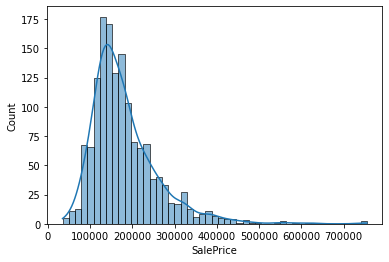

1.8828757597682129
6.536281860064529


In [26]:
print(train['SalePrice'].describe())
sns.histplot(train['SalePrice'], kde=True)
plt.show()
# Seeing The Plot
## Deviates from a normal distribution
## Positive Skewed, Long Right Tail
## Peak is high ie More instances around mean/median, High Kurtosis

# Let's Check the exact numbers for skewness and Kurtosis
print(train['SalePrice'].skew())
print(train['SalePrice'].kurt())

count    1460.000000
mean        2.486358
std         0.033214
min         2.347582
25%         2.465987
50%         2.485032
75%         2.507461
max         2.605240
Name: SalePrice, dtype: float64
-0.02037671523503421
0.8976549705443784


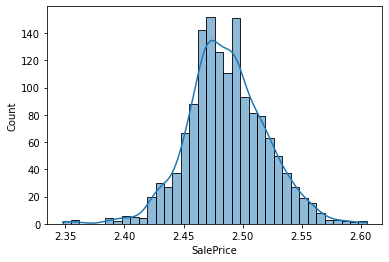

In [113]:
y = np.log(train['SalePrice'])
print(y.describe())
sns.histplot(y, kde=True)
print(y.skew())
print(y.kurt())

In [114]:
train['SalePrice'] = y

In [115]:
train._get_numeric_data().corr()['SalePrice'].sort_values()

EnclosedPorch   -0.149920
KitchenAbvGr    -0.147187
MSSubClass      -0.072328
LowQualFinSF    -0.038503
YrSold          -0.037950
OverallCond     -0.031804
MiscVal         -0.019933
Id              -0.017263
BsmtHalfBath    -0.003492
BsmtFinSF2       0.006367
3SsnPorch        0.055358
MoSold           0.057420
PoolArea         0.068329
ScreenPorch      0.121469
BedroomAbvGr     0.211982
BsmtUnfSF        0.220911
BsmtFullBath     0.235637
LotArea          0.255209
HalfBath         0.314676
2ndFlrSF         0.317535
OpenPorchSF      0.318562
WoodDeckSF       0.332999
LotFrontage      0.354168
BsmtFinSF1       0.369378
MasVnrArea       0.424924
Fireplaces       0.488364
TotRmsAbvGrd     0.531796
GarageYrBlt      0.542726
YearRemodAdd     0.566881
YearBuilt        0.588027
1stFlrSF         0.593226
FullBath         0.593850
TotalBsmtSF      0.608866
GarageArea       0.649467
GarageCars       0.680087
GrLivArea        0.696648
OverallQual      0.814790
SalePrice        1.000000
Name: SalePr

<AxesSubplot:>

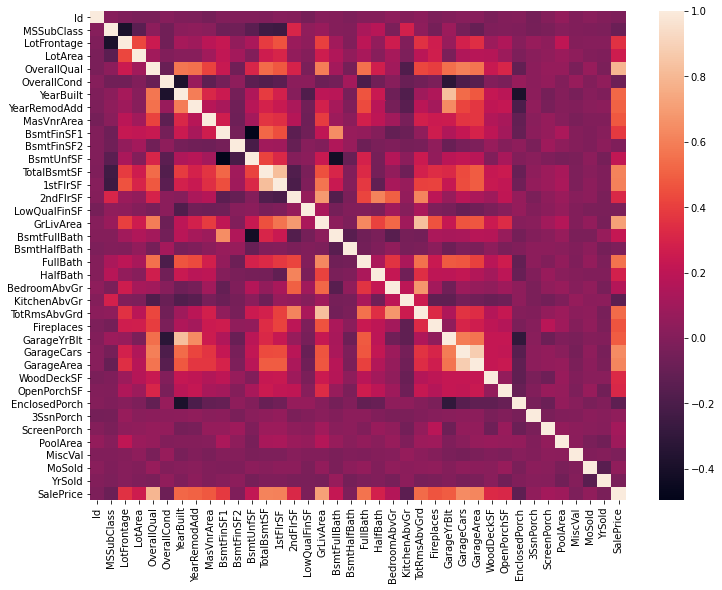

In [157]:
f, ax = plt.subplots(figsize=(12,9))
corrmat = train.corr()
sns.heatmap(corrmat)

# There seems a lot of light suqares and dark squares between features, 
# that indicates features are collinear and needs to be removed

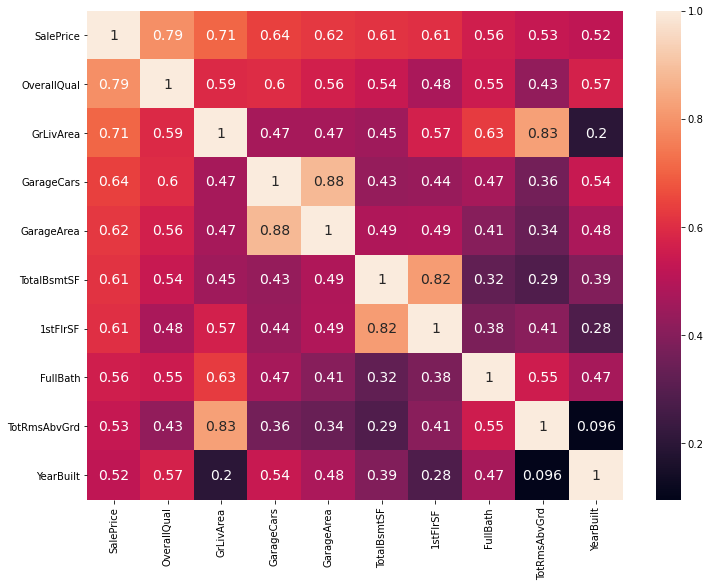

In [163]:
k = 10 #number of variables for heatmap
cols_top = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

f, ax = plt.subplots(figsize=(12,9))
corrmat_sub = train[cols_top].corr()
#print(corrmat)

sns.heatmap(corrmat_sub, annot=True, annot_kws={'size': 14})
plt.show()

# Overall Quality is highly correlated with SalePrice. Not Sure what's the calcualtion of OverallQual
# GarageArea and GarageCars are correlated, chooose any one, maybe GarageCars of more correlation with SalePrice
#   Or get average GarageArea by Cars and average it with GarageArea, and this average quantity has more correlation
#   then the original ones
# TotalBsmtSF is highly correlated with 1stFlrSF, I think just take the average of both and drop other and you 
#   will see that avg has more correlation with final
# For TotRmsAbvGrd and GrLivArea do same as above, but the average will have lower correlation so 
# just drop the TotRmsAbvGrd
# Not sure what's FullBath here, so may trying a model dropping it.
# 

In [252]:
top_corr = get_top_corr_by_features(train.corr(), 5)


In [256]:
top_corr.sort_values(['0_Corr'], ascending=False)

,0_Corr,0_Top_Col,1_Corr,1_Top_Col,2_Corr,2_Top_Col,3_Corr,3_Top_Col
GarageArea,0.882475,GarageCars,0.623431,SalePrice,0.564567,GarageYrBlt,0.562022,OverallQual
GarageCars,0.882475,GarageArea,0.640409,SalePrice,0.600671,OverallQual,0.58892,GarageYrBlt
GarageYrBlt,0.825667,YearBuilt,0.642277,YearRemodAdd,0.58892,GarageCars,0.564567,GarageArea
YearBuilt,0.825667,GarageYrBlt,0.592855,YearRemodAdd,0.572323,OverallQual,0.53785,GarageCars
GrLivArea,0.825489,TotRmsAbvGrd,0.708624,SalePrice,0.687501,2ndFlrSF,0.630012,FullBath
TotRmsAbvGrd,0.825489,GrLivArea,0.67662,BedroomAbvGr,0.616423,2ndFlrSF,0.554784,FullBath
TotalBsmtSF,0.81953,1stFlrSF,0.613581,SalePrice,0.537808,OverallQual,0.522396,BsmtFinSF1
1stFlrSF,0.81953,TotalBsmtSF,0.605852,SalePrice,0.566024,GrLivArea,0.489782,GarageArea
SalePrice,0.790982,OverallQual,0.708624,GrLivArea,0.640409,GarageCars,0.623431,GarageArea
OverallQual,0.790982,SalePrice,0.600671,GarageCars,0.593007,GrLivArea,0.572323,YearBuilt


In [144]:
# Feature Engineering


print(train['FullBath'].value_counts())
print(train.groupby('GarageCars')['GarageArea'].mean())
train['f_GarageCars_and_Area_Avg'] = (
    train['GarageArea'] + 
    train.groupby('GarageCars')['GarageArea'].transform(np.mean)
)/2

train['Bsmt1stFlrSF_Avg'] = (train['TotalBsmtSF']+train['1stFlrSF'])/2

train.drop(['TotRmsAbvGrd', 'GarageArea',
           'GarageCars','TotalBsmtSF','1stFlrSF'], axis=1, inplace=True
      )

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64
GarageCars
0      0.000000
1    300.517615
2    519.797330
3    811.574586
4    890.400000
Name: GarageArea, dtype: float64


In [ ]:
sns.pairplot(train[cols10], height = 2.5)
plt.show();

In [127]:

def get_distr_features_vs_target(data, target_name):
    summary = pd.DataFrame()
    for feature in data.columns:
        #print(feature)
        nas = ~data[target_name].isna() & ~data[feature].isna()
        temp = data.groupby(feature)[[target_name]].mean().round()
        temp.insert(0,'feature',feature)
        summary = pd.concat([summary, temp])
    return summary


In [128]:
result = get_distr_features_vs_target(
    pd.concat([
        train.select_dtypes(include=['object']),
        train['SalePrice']], axis=1
    ),
    'SalePrice')

In [320]:
# Seems similar Missingness in test and train
pd.concat([
    get_missing_rate(train),
    get_missing_rate(test)
], axis=1)
# PoolQC, Miscfeature, Alley, Fence has more than 50% missing data

,0,1
PoolQC,100.0,100.0
MiscFeature,96.0,97.0
Alley,94.0,93.0
Fence,81.0,80.0
FireplaceQu,47.0,50.0
LotFrontage,18.0,16.0
GarageType,6.0,5.0
GarageCond,6.0,5.0
GarageYrBlt,6.0,5.0
GarageFinish,6.0,5.0


<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

                    count      mean       std       min       25%       50%  \
variable    value                                                             
Alley       Grvl     50.0  122219.0   34781.0   52500.0  105312.0  119500.0   
            NONE   1369.0  183452.0   80667.0   34900.0  130500.0  165000.0   
            Pave     41.0  168001.0   38370.0   40000.0  151000.0  172500.0   
Fence       GdPrv    59.0  178927.0   56757.0  108000.0  144950.0  167500.0   
            GdWo     54.0  140379.0   53593.0   34900.0  118625.0  138750.0   
            MnPrv   157.0  148751.0   66096.0   40000.0  119900.0  137450.0   
            MnWw     11.0  134286.0   21782.0  110000.0  121500.0  130000.0   
            NONE   1179.0  187597.0   81656.0   35311.0  132750.0  173000.0   
FireplaceQu Ex       24.0  337712.0  123611.0  130500.0  265070.0  314250.0   
            Fa       33.0  167298.0   34288.0  117000.0  143000.0  158000.0   
            Gd      380.0  226351.0   91123.0   9035

/home/vss/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vss/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


FireplaceQu  Fireplaces
NONE         0             690
Gd           1             324
TA           1             259
Gd           2              54
TA           2              53
Fa           1              28
Po           1              20
Ex           1              19
Fa           2               4
Ex           2               4
Gd           3               2
TA           3               1
Fa           3               1
Ex           3               1
dtype: int64

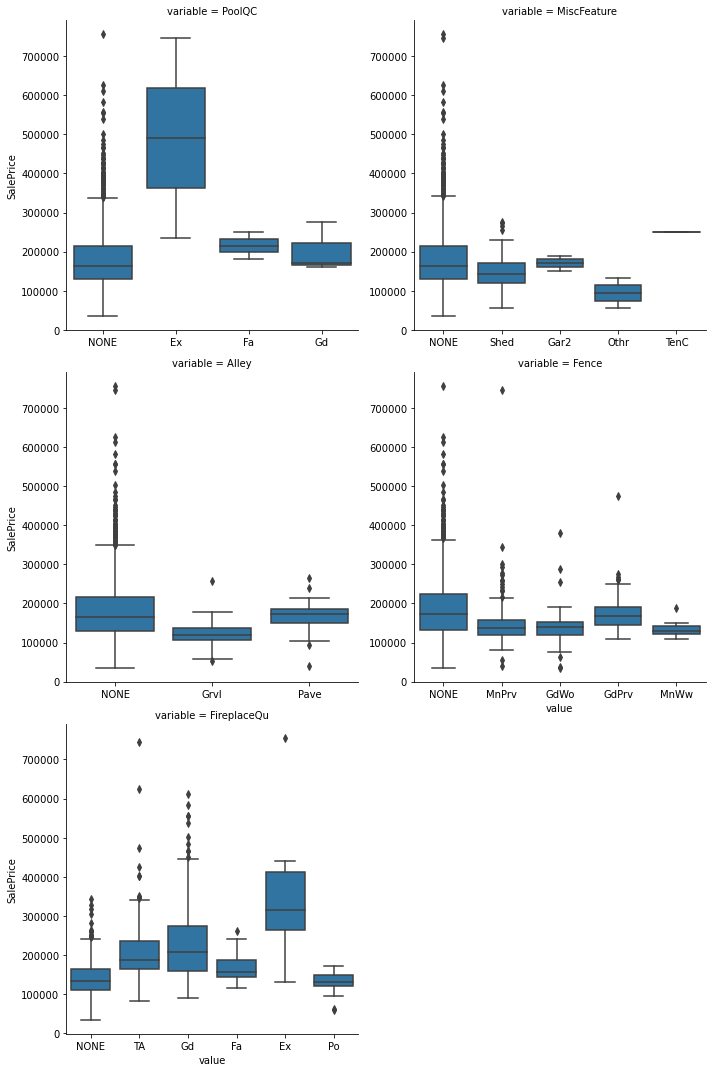

In [321]:
missing_vars= ['PoolQC','MiscFeature','Alley', 'Fence', 'FireplaceQu']
data = train[ missing_vars +['SalePrice']].fillna('NONE').melt(id_vars='SalePrice', value_vars=missing_vars)
print(data.groupby(['variable','value'])['SalePrice'].describe().round())
g = sns.FacetGrid(data, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5, palette = 'tab10')
g = g.map(sns.boxplot, 'value', 'SalePrice')
#.groupby(['PoolQC','MiscFeature','Alley', 'Fence'])['SalePrice'].describe()

# As you can clearly, when the FirePlaces is 0, the Fireplacequ is missing. So Just replace it with NONE
train[['FireplaceQu', 'Fireplaces']].fillna('NONE').value_counts()

# Drop PoolQC as it doesn't has many counts
# Drop Fence also, as the variability is not high wrt sale price
# Drop All 4 actually
# Keep 'FireplaceQ' as it has aroud 50% fillin rate and has good variability for 'SalePrice'


In [368]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(random_state=18)
train[['LotArea','LotFrontage', '1stFlrSF']] = imputer.fit_transform(train[['LotArea','LotFrontage', '1stFlrSF']])

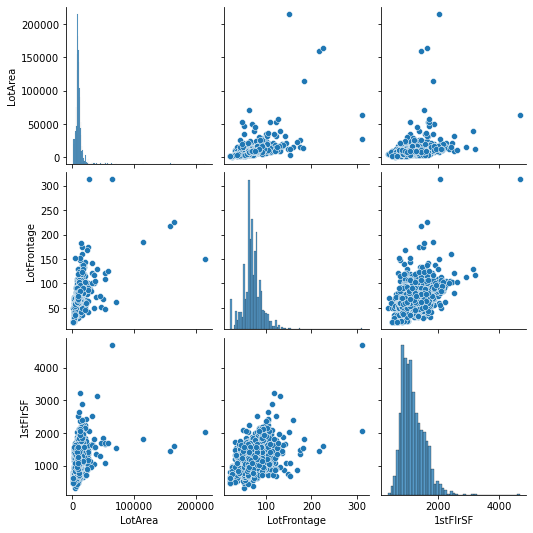

In [350]:
# How to impute missingness for LotFrontage

sns.pairplot(pd.DataFrame(temp, columns = ['LotArea','LotFrontage', '1stFlrSF']), height = 2.5)
plt.show();

In [361]:
# As you see, if there is no Garage then there is no values for the attributes that defines it.
# So best thing is to fill NONE for categorical variables for Garage
# And drop the GarageYrBlt' as it correlates with "YearBlt" 
train[['GarageCars','GarageCond', 'GarageFinish', 'GarageType', 'GarageYrBlt']].fillna(-1).value_counts()

GarageCars  GarageCond  GarageFinish  GarageType  GarageYrBlt
0           -1          -1            -1          -1.0           81
2           TA          Fin           Attchd       2005.0        23
                        RFn           Attchd       2004.0        20
                                                   2006.0        19
3           TA          RFn           Attchd       2006.0        15
                                                                 ..
2           TA          RFn           Basment      1988.0         1
                                                   2005.0         1
                                      BuiltIn      1977.0         1
                                                   1993.0         1
                        Fin           Detchd       2002.0         1
Length: 571, dtype: int64

In [366]:
train[['BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2']].fillna(-1).value_counts()
train[['MasVnrArea','MasVnrType']].fillna(-1).value_counts()

MasVnrArea  MasVnrType
 0.0        None          859
-1.0        -1              8
 120.0      BrkFace         7
 180.0      BrkFace         7
 108.0      BrkFace         6
                         ... 
 306.0      BrkFace         1
            Stone           1
 309.0      BrkFace         1
 310.0      BrkFace         1
 234.0      BrkFace         1
Length: 402, dtype: int64

In [299]:
train.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

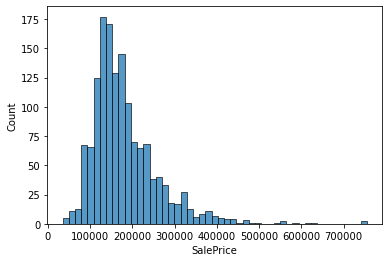

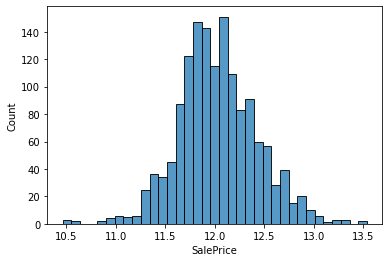

In [151]:
sns.histplot(train['SalePrice'])
plt.show()
# Sale Price doesn't follow a normal distribution
# Apply a log transformation
sns.histplot(np.log1p(train['SalePrice']))
plt.show()


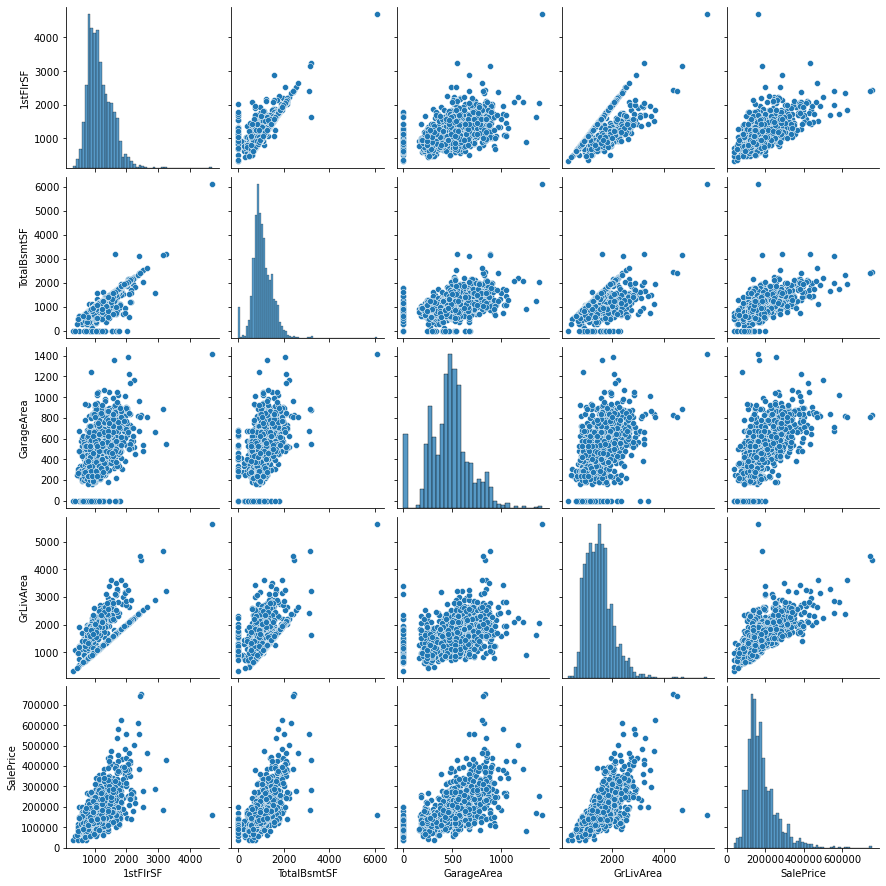

In [394]:
cols = ['1stFlrSF','TotalBsmtSF','GarageArea','GrLivArea','SalePrice']
sns.pairplot(pd.DataFrame(train, columns = cols), height = 2.5)
plt.show();

In [391]:
temp = np.log(train[['1stFlrSF','TotalBsmtSF','GarageArea','GrLivArea','SalePrice']]+1)


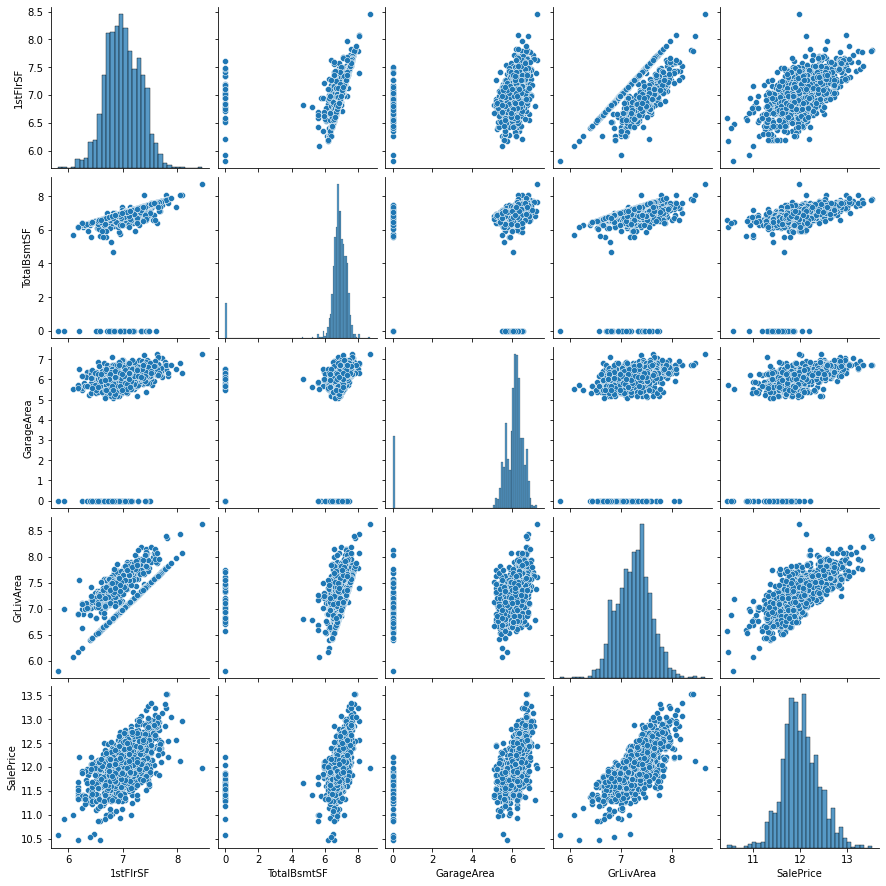

In [395]:
cols = ['1stFlrSF','TotalBsmtSF','GarageArea','GrLivArea','SalePrice']
sns.pairplot(pd.DataFrame(temp, columns = cols), height = 2.5)
plt.show();

In [393]:
temp

,1stFlrSF,TotalBsmtSF,GarageArea,GrLivArea,SalePrice
0,6.753438,6.753438,6.308098,7.444833,12.247699
1,7.141245,7.141245,6.133398,7.141245,12.109016
2,6.825460,6.825460,6.411818,7.488294,12.317171
3,6.869014,6.629363,6.466145,7.448916,11.849405
4,7.044033,7.044033,6.729824,7.695758,12.429220
...,...,...,...,...,...
1455,6.860664,6.860664,6.133398,7.407318,12.072547
1456,7.637234,7.341484,6.216606,7.637234,12.254868
1457,7.080868,7.050123,5.533389,7.758333,12.493133
1458,6.983790,6.983790,5.484797,6.983790,11.864469


In [388]:
np.log(7.44+1)

2.132982308607866

In [160]:
categorical_features = train.select_dtypes(include=['object']).columns
cat_target = pd.melt(train, id_vars = 'SalePrice', value_vars = categorical_features)

/home/vss/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vss/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


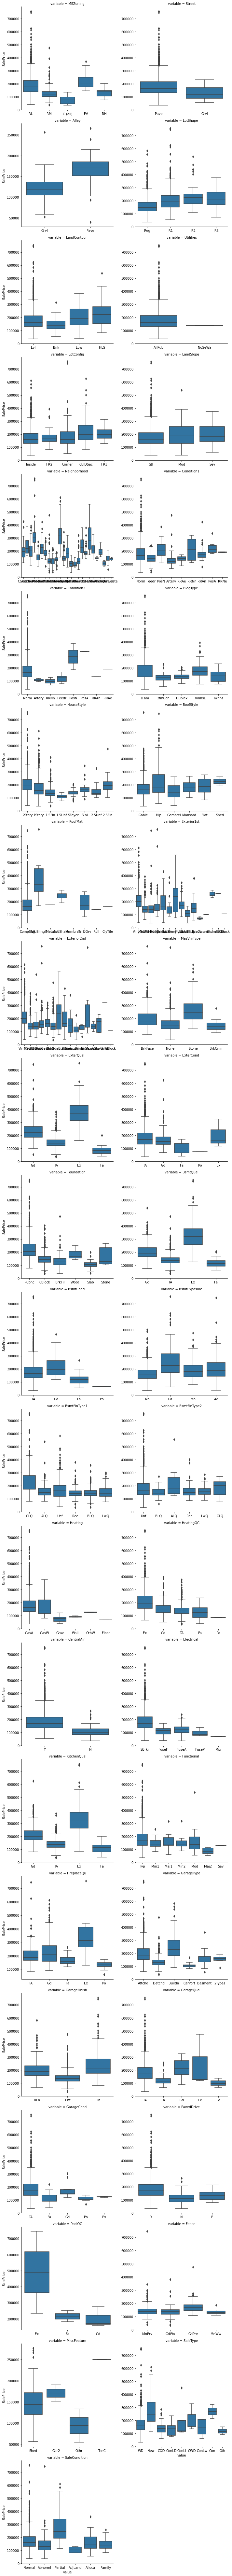

In [162]:
g = sns.FacetGrid(cat_target, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5, palette = 'tab10')
g = g.map(sns.boxplot, 'value', 'SalePrice')